In [1]:
include("MyActor3.jl")
using .MyActor

In [2]:
using Distributions
NUM_DIZITIZED = 8
GAMMA = 0.99  # 時間割引率
ETA = 0.5  # 学習係数

spaces = [
    collect(range(-2.4, 2.4, length=7)),
    collect(range(-3.0, 3.0, length=7)),
    collect(range(-0.5, 0.5, length=7)),
    collect(range(-2.0, 2.0, length=7)),
]
function digitize_state(observation)
    return [searchsortedfirst(spaces[i], observation[i]) for i in 1:4]
end

struct Agent <: Actor
    num_actions::Int
    q_table::Array{Float32, 5}
    Agent(num_actions::Int) = new(num_actions, 
        zeros(Float32, (num_actions, NUM_DIZITIZED, NUM_DIZITIZED, NUM_DIZITIZED, NUM_DIZITIZED)))
    #        rand(Uniform(-1, 1), (NUM_DIZITIZED, NUM_DIZITIZED, NUM_DIZITIZED, NUM_DIZITIZED, num_actions)))
end    





In [4]:
@remote function get_action(agent::Agent, observation::Vector{Float32}, step::Int)
    epsilon = 0.5 * (1 / (step + 1))
    if epsilon <= rand()
        return argmax(agent.q_table[:, digitize_state(observation)...])
    else
        return rand(1:agent.num_actions)
    end
end

get_action (generic function with 2 methods)

In [5]:
@remote function update_Qtable(agent::Agent, observation::Vector{Float32}, action::Int, reward, observation_next::Vector{Float32})
    state = digitize_state(observation)
    state_next = digitize_state(observation_next)
    Max_Q_next = maximum(agent.q_table[:, state_next...])
    agent.q_table[action, state...] = agent.q_table[action, state...] + ETA * (reward + GAMMA * Max_Q_next - agent.q_table[action, state...])
end


update_Qtable (generic function with 2 methods)

In [5]:
a = Agent(2)
v = (1,2,3,4)
a.q_table[:, v...]

2-element Vector{Float32}:
 0.0
 0.0

In [10]:
using PyCall

MAX_STEPS = 500
NUM_EPISODES = 1000
gym = pyimport("gymnasium")

env = gym.make("CartPole-v1")
num_actions = 2
agent = @startat 1 Agent(2)
step_list = []

for episode in 1:NUM_EPISODES
    observation, info = env.reset(seed=42)
    for step in 1:MAX_STEPS
        action = fetch(get_action(agent, observation, episode))
        observeration_next, reward, terminated, truncated, info = env.step(action - 1)
        if terminated
#            print(".")
            reward = -1
        elseif truncated
#            print("!")
            reward = 1
        else
            reward = 0
        end
        fetch(update_Qtable(agent, observation, action, reward, observeration_next))
        observation = observeration_next
        if terminated | truncated
            append!(step_list, step)
            break
        end
    end
end
env.close()


In [11]:
using Plots
step_list

1000-element Vector{Any}:
  12
   9
   8
   9
  10
  10
   8
   9
   8
   9
   ⋮
 101
 111
 109
 101
 138
 138
 146
 124
 131

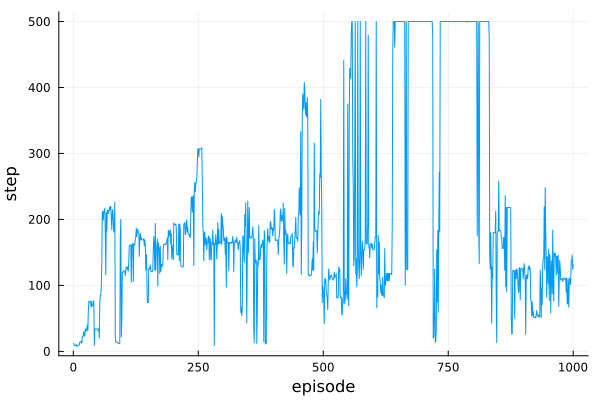

In [12]:
plot(step_list, legend=false, xlabel="episode", ylabel="step")

In [75]:
include("MyActor3.jl")
using .MyActor

In [78]:
mutable struct Counter <: Actor
    count::Int
end

@remote add(c::Counter, x::Int) = c.count += x







add (generic function with 2 methods)

In [81]:
c = @startat 1 Counter(0)

ActorRef(Distributed.RemoteChannel{Channel{Any}}(1, 1, 2), 1)

In [84]:
fetch(add(c,1))

3